In [1]:
import pandas as pd

# Obtener parejas y reportes

In [2]:
df_report_pairs = pd.read_pickle('data/raw_report_pairs.pkl')
df_reports = pd.read_pickle('data/raw_reports.pkl')

In [3]:
df_report_pairs.sample(3)

,type,id_M,id_D,statusM,statusD,componentM,componentD,summaryM,summaryD,commentsM,commentsD,text1M,text1D,text2M,text2D,text3M,text3D,text4M,text4D
2610,master,1610024,1652487,VERIFIED,RESOLVED,Address Bar,Toolbars and Customization,"The ""Redirect"" tip is not triggered in the nex...",BrowserUsageTelemetry.jsm: SyntaxError: Elemen...,+++ This bug was initially created as a clone ...,I opened the global JS console and see the fol...,"The ""Redirect"" tip is not triggered in the nex...",BrowserUsageTelemetry.jsm: SyntaxError: Elemen...,"The ""Redirect"" tip is not triggered in the nex...",BrowserUsageTelemetry.jsm: SyntaxError: Elemen...,"The ""Redirect"" tip is not triggered in the nex...",BrowserUsageTelemetry.jsm: SyntaxError: Elemen...,"The ""Redirect"" tip is not triggered in the nex...",BrowserUsageTelemetry.jsm: SyntaxError: Elemen...
524,duplicate,1259652,1743810,RESOLVED,RESOLVED,Networking: Cookies,Security,Security issue : You should Provide password t...,Make Primary Password encrypt cookie db too,User Agent: Mozilla/5.0 (Macintosh; Intel Mac ...,User Agent: Mozilla/5.0 (X11; Linux x86_64; rv...,Security issue : You should Provide password t...,Make Primary Password encrypt cookie db too,Security issue : You should Provide password t...,Make Primary Password encrypt cookie db too Se...,Security issue : You should Provide password t...,Make Primary Password encrypt cookie db too Us...,Security issue : You should Provide password t...,Make Primary Password encrypt cookie db too Se...
3520,master,1675190,1686525,RESOLVED,VERIFIED,General,Toolbars and Customization,Vendor new application services into mozilla-c...,Automatically add the home button to the toolb...,We need a new app-services to fix bug 1667985 ...,"When a user customizes their homepage, the Hom...",Vendor new application services into mozilla-c...,Automatically add the home button to the toolb...,Vendor new application services into mozilla-c...,Automatically add the home button to the toolb...,Vendor new application services into mozilla-c...,Automatically add the home button to the toolb...,Vendor new application services into mozilla-c...,Automatically add the home button to the toolb...


In [4]:
df_reports.sample(3)

,report_id,creation_time,status,component,dupe_of,summary,comments,text1,text2,text3,text4
4479,1728990,2021-09-03 13:39:15,RESOLVED,Nimbus Desktop Client,NaN,Require exposure event description in FeatureM...,We would like to have a required field for a d...,Require exposure event description in FeatureM...,Require exposure event description in FeatureM...,Require exposure event description in FeatureM...,Require exposure event description in FeatureM...
3312,1774022,2022-06-13 14:43:15,RESOLVED,Nimbus Desktop Client,NaN,Increase strictness of schema-less validation ...,Experimenter now validates `int` field types a...,Increase strictness of schema-less validation ...,Increase strictness of schema-less validation ...,Increase strictness of schema-less validation ...,Increase strictness of schema-less validation ...
2937,1677723,2020-11-17 13:05:39,VERIFIED,Messaging System,NaN,Telemetry pings are not displayed in Browser C...,[Affected versions]\nFirefox 84.0b1\n\n[Affect...,Telemetry pings are not displayed in Browser C...,Telemetry pings are not displayed in Browser C...,Telemetry pings are not displayed in Browser C...,Telemetry pings are not displayed in Browser C...


# Preprocesamiento

## Caracteres extra

In [5]:
from string import punctuation
EXTRA_CHARACTERS = [p for p in punctuation if p not in list('_')]
ALLOWED_URL_CHARS = [':', '/', '?', '=', '&', '#']
URL_FORBIDDEN_CHARS = [c for c in EXTRA_CHARACTERS if c not in ALLOWED_URL_CHARS]

EXTRA_CHARACTERS = [p for p in punctuation if p not in list('_')]
URL_FORBIDDEN_CHARS = [c for c in EXTRA_CHARACTERS if c in [':', '/', '?', '=', '&', '#', '.']]

In [6]:
def process_token(token: str) -> list:
    token = token.lower()

    if token.startswith('http'):

        token = ''.join(
            [w if w not in URL_FORBIDDEN_CHARS else ' ' for w in token]
        )
    else:
        token = ''.join(
            [w if w not in EXTRA_CHARACTERS else ' ' for w in token]
        )

    token = token.strip()
    tokens = token.split() if len(token.split()) > 1 else [token]
    tokens = [t for t in tokens if not t.isdigit()]
    return tokens

In [7]:
def remove_extra_characters(sentence: str) -> list:

    sentence_to_process = sentence.split() # Generar tokens por espacios
    sentence_processed = []

    # Eliminar tokens que sean solo números
    sentence_processed = [w for w in sentence_to_process if not w.isdigit()]
    # Eliminar tokens que sean solo puntuación
    sentence_processed = [w for w in sentence_processed if w not in list(punctuation)]

    result = []
    for w in sentence_processed:
        token = process_token(w)
        if len(token) > 1:
            for subtoken in token:
                result.extend(process_token(subtoken))
        else:
            result.extend(token)
    
    return result

## StopWords

In [8]:
from nltk.corpus import stopwords

CUSTOM_WORDS = ['info', 'https', 'http', 'org', 'com', 'net', 'edu']
CUSTOM_WORDS.extend([chr(i) for i in range(ord('a'), ord('z') + 1)])

def remove_stopwords(sentence: list) -> list:
    return [w for w in sentence if w not in stopwords.words('english') and w not in CUSTOM_WORDS]

## Lematización y stemming

In [9]:
import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

LEMMATIZER = WordNetLemmatizer()
LEMMATIZER_PASS_TOKENS = ['js']

def lemmatize(sentence: list) -> list:
    return [LEMMATIZER.lemmatize(w) if w not in LEMMATIZER_PASS_TOKENS else w for w in sentence ]

[nltk_data] Downloading package omw-1.4 to /home/ajburri/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
from nltk.stem import SnowballStemmer
STEMMER = SnowballStemmer('english')
STEMMER_PASS_TOKENS = ['js']

def stem(sentence: list) -> list:
    return [STEMMER.stem(w) if w not in STEMMER_PASS_TOKENS else w for w in sentence]

# Aplicación y resultados

In [11]:
def preprocess_with_lemmatizer(sentence: str) -> str:
    # Pasar a minusculas
    p_sentence = sentence.lower()
    # Eliminar puntuación
    p_sentence = remove_extra_characters(p_sentence)
    # Eliminar palabras que no sean stopwords
    p_sentence = remove_stopwords(p_sentence)
    # Lematizar
    p_sentence = lemmatize(p_sentence)
    # Últimas modificaciones
    p_sentence = [t for t in p_sentence if t not in ['', ' ']]
    return p_sentence

In [12]:
def preprocess_with_stemmer(sentence: str) -> str:
    # Pasar a minusculas
    p_sentence = sentence.lower()
    # Eliminar puntuación
    p_sentence = remove_extra_characters(p_sentence)
    # Eliminar palabras que no sean stopwords
    p_sentence = remove_stopwords(p_sentence)
    # Lematizar
    p_sentence = stem(p_sentence)
    # Últimas modificaciones
    p_sentence = [t for t in p_sentence if t not in ['', ' ']]
    return p_sentence

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

## Conjunto total

In [14]:
df_reports['tokens1L'] = df_reports['text1'].apply(preprocess_with_lemmatizer)
df_reports['tokens2L'] = df_reports['text2'].apply(preprocess_with_lemmatizer)
df_reports['tokens3L'] = df_reports['text3'].apply(preprocess_with_lemmatizer)
df_reports['tokens4L'] = df_reports['text4'].apply(preprocess_with_lemmatizer)
df_reports['tokens1S'] = df_reports['text1'].apply(preprocess_with_stemmer)
df_reports['tokens2S'] = df_reports['text2'].apply(preprocess_with_stemmer)
df_reports['tokens3S'] = df_reports['text3'].apply(preprocess_with_stemmer)
df_reports['tokens4S'] = df_reports['text4'].apply(preprocess_with_stemmer)
df_reports.sample(3)

,report_id,creation_time,status,component,dupe_of,summary,comments,text1,text2,text3,text4,tokens1L,tokens2L,tokens3L,tokens4L,tokens1S,tokens2S,tokens3S,tokens4S
0,1693784,2021-02-19 13:11:22,NEW,PDF Viewer,NaN,find toolbar highlight on scrollbar doesn't wo...,User Agent: Mozilla/5.0 (X11; Linux x86_64; rv...,find toolbar highlight on scrollbar doesn't wo...,find toolbar highlight on scrollbar doesn't wo...,find toolbar highlight on scrollbar doesn't wo...,find toolbar highlight on scrollbar doesn't wo...,"[find, toolbar, highlight, scrollbar, work, pdfs]","[find, toolbar, highlight, scrollbar, work, pd...","[find, toolbar, highlight, scrollbar, work, pd...","[find, toolbar, highlight, scrollbar, work, pd...","[find, toolbar, highlight, scrollbar, work, pdfs]","[find, toolbar, highlight, scrollbar, work, pd...","[find, toolbar, highlight, scrollbar, work, pd...","[find, toolbar, highlight, scrollbar, work, pd..."
4709,1672764,2020-10-22 16:24:27,RESOLVED,Pocket,NaN,Logged Out Save: Build variants,Figma: https://www.figma.com/proto/NtBrBrePv0g...,Logged Out Save: Build variants,Logged Out Save: Build variants Pocket,Logged Out Save: Build variants Figma: https:/...,Logged Out Save: Build variants Pocket,"[logged, save, build, variant]","[logged, save, build, variant, pocket]","[logged, save, build, variant, figma, www, fig...","[logged, save, build, variant, pocket]","[log, save, build, variant]","[log, save, build, variant, pocket]","[log, save, build, variant, figma, www, figma,...","[log, save, build, variant, pocket]"
242,1781883,2022-07-27 18:36:15,NEW,Preferences,NaN,Intermittent browser/components/preferences/te...,,Intermittent browser/components/preferences/te...,Intermittent browser/components/preferences/te...,Intermittent browser/components/preferences/te...,Intermittent browser/components/preferences/te...,"[intermittent, browser, component, preference,...","[intermittent, browser, component, preference,...","[intermittent, browser, component, preference,...","[intermittent, browser, component, preference,...","[intermitt, browser, compon, prefer, test, bro...","[intermitt, browser, compon, prefer, test, bro...","[intermitt, browser, compon, prefer, test, bro...","[intermitt, browser, compon, prefer, test, bro..."


In [15]:
unique_tokens1L = set(word for tokens in df_reports['tokens1L'] for word in tokens)
unique_tokens2L = set(word for tokens in df_reports['tokens2L'] for word in tokens)
unique_tokens3L = set(word for tokens in df_reports['tokens3L'] for word in tokens)
unique_tokens4L = set(word for tokens in df_reports['tokens4L'] for word in tokens)
unique_tokens1S = set(word for tokens in df_reports['tokens1S'] for word in tokens)
unique_tokens2S = set(word for tokens in df_reports['tokens2S'] for word in tokens)
unique_tokens3S = set(word for tokens in df_reports['tokens3S'] for word in tokens)
unique_tokens4S = set(word for tokens in df_reports['tokens4S'] for word in tokens)

print(f"Número de tokens únicos con lemmatizer en Conjunto 1: {len(unique_tokens1L)}")
print(f"Número de tokens únicos con lemmatizer en Conjunto 2: {len(unique_tokens2L)}")
print(f"Número de tokens únicos con lemmatizer en Conjunto 3: {len(unique_tokens3L)}")
print(f"Número de tokens únicos con lemmatizer en Conjunto 4: {len(unique_tokens4L)}")
print('-'*70)
print(f"Número de tokens únicos con stemmer en Conjunto 1: {len(unique_tokens1S)}")
print(f"Número de tokens únicos con stemmer en Conjunto 2: {len(unique_tokens2S)}")
print(f"Número de tokens únicos con stemmer en Conjunto 3: {len(unique_tokens3S)}")
print(f"Número de tokens únicos con stemmer en Conjunto 4: {len(unique_tokens4S)}")

Número de tokens únicos con lemmatizer en Conjunto 1: 5275
Número de tokens únicos con lemmatizer en Conjunto 2: 5303
Número de tokens únicos con lemmatizer en Conjunto 3: 11925
Número de tokens únicos con lemmatizer en Conjunto 4: 6278
----------------------------------------------------------------------
Número de tokens únicos con stemmer en Conjunto 1: 4325
Número de tokens únicos con stemmer en Conjunto 2: 4346
Número de tokens únicos con stemmer en Conjunto 3: 9769
Número de tokens únicos con stemmer en Conjunto 4: 5080


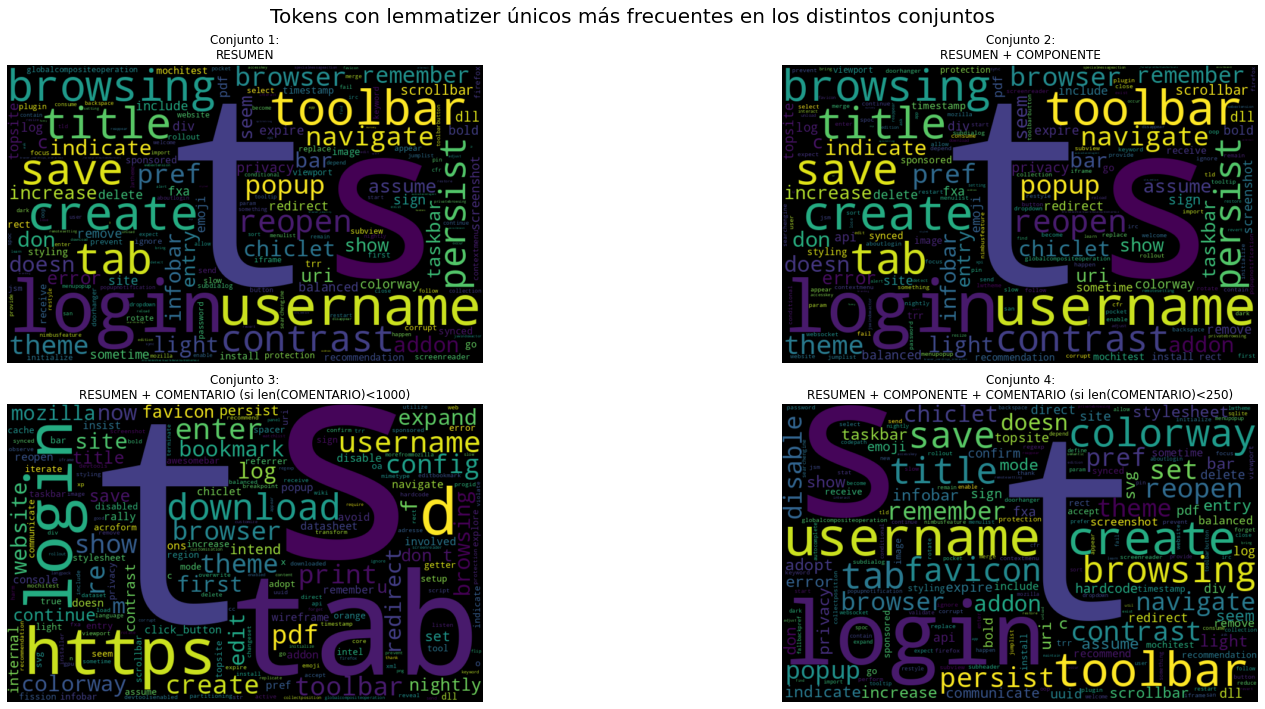

In [16]:
tokens1L_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens1L))
tokens2L_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens2L))
tokens3L_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens3L))
tokens4L_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens4L))

fig, axs = plt.subplots(2,2, figsize=(25,10))

axs[0,0].imshow(tokens1L_wordcloud, interpolation='bilinear')
axs[0,0].set_title('Conjunto 1:\nRESUMEN')
axs[0,0].axis('off')

axs[0,1].imshow(tokens2L_wordcloud, interpolation='bilinear')
axs[0,1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0,1].axis('off')

axs[1,0].imshow(tokens3L_wordcloud, interpolation='bilinear')
axs[1,0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1,0].axis('off')

axs[1,1].imshow(tokens4L_wordcloud, interpolation='bilinear')
axs[1,1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1,1].axis('off')

fig.suptitle('Tokens con lemmatizer únicos más frecuentes en los distintos conjuntos', fontsize=20)
fig.tight_layout()
plt.show()


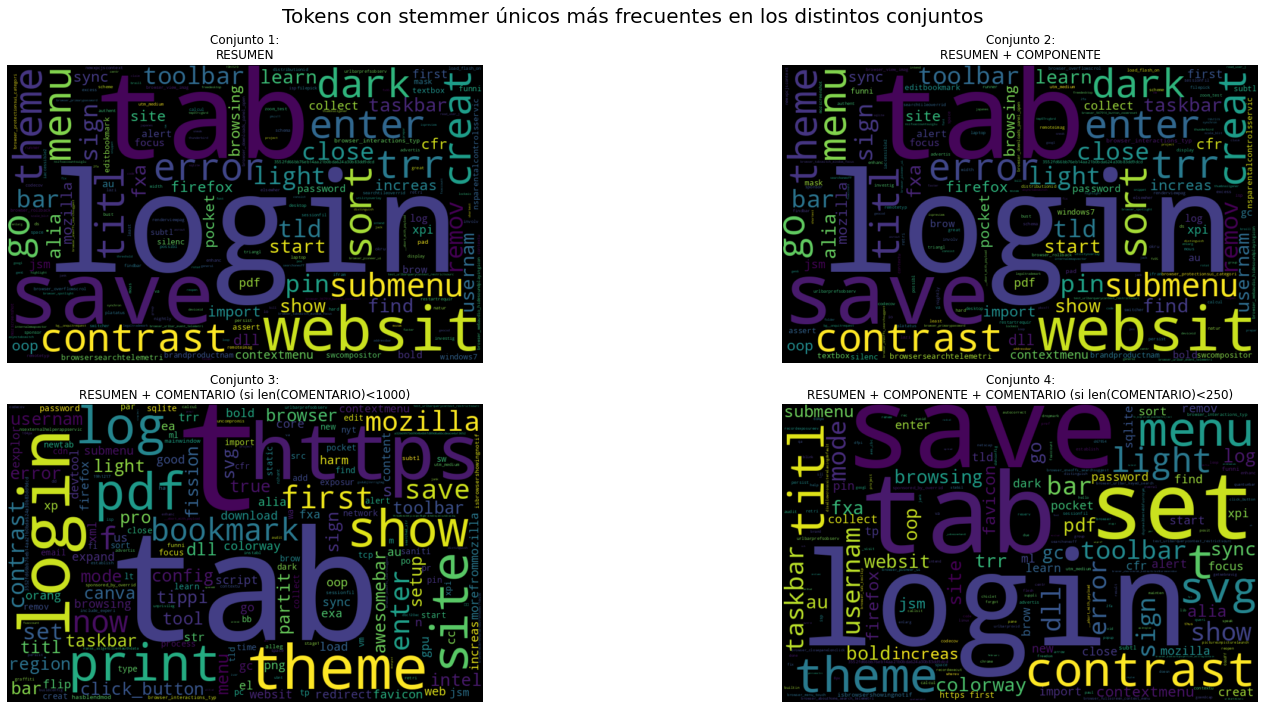

In [17]:
tokens1S_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens1S))
tokens2S_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens2S))
tokens3S_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens3S))
tokens4S_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens4S))

fig, axs = plt.subplots(2,2, figsize=(25,10))

axs[0,0].imshow(tokens1S_wordcloud, interpolation='bilinear')
axs[0,0].set_title('Conjunto 1:\nRESUMEN')
axs[0,0].axis('off')

axs[0,1].imshow(tokens2S_wordcloud, interpolation='bilinear')
axs[0,1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0,1].axis('off')

axs[1,0].imshow(tokens3S_wordcloud, interpolation='bilinear')
axs[1,0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1,0].axis('off')

axs[1,1].imshow(tokens4S_wordcloud, interpolation='bilinear')
axs[1,1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1,1].axis('off')

fig.suptitle('Tokens con stemmer únicos más frecuentes en los distintos conjuntos', fontsize=20)
fig.tight_layout()
plt.show()


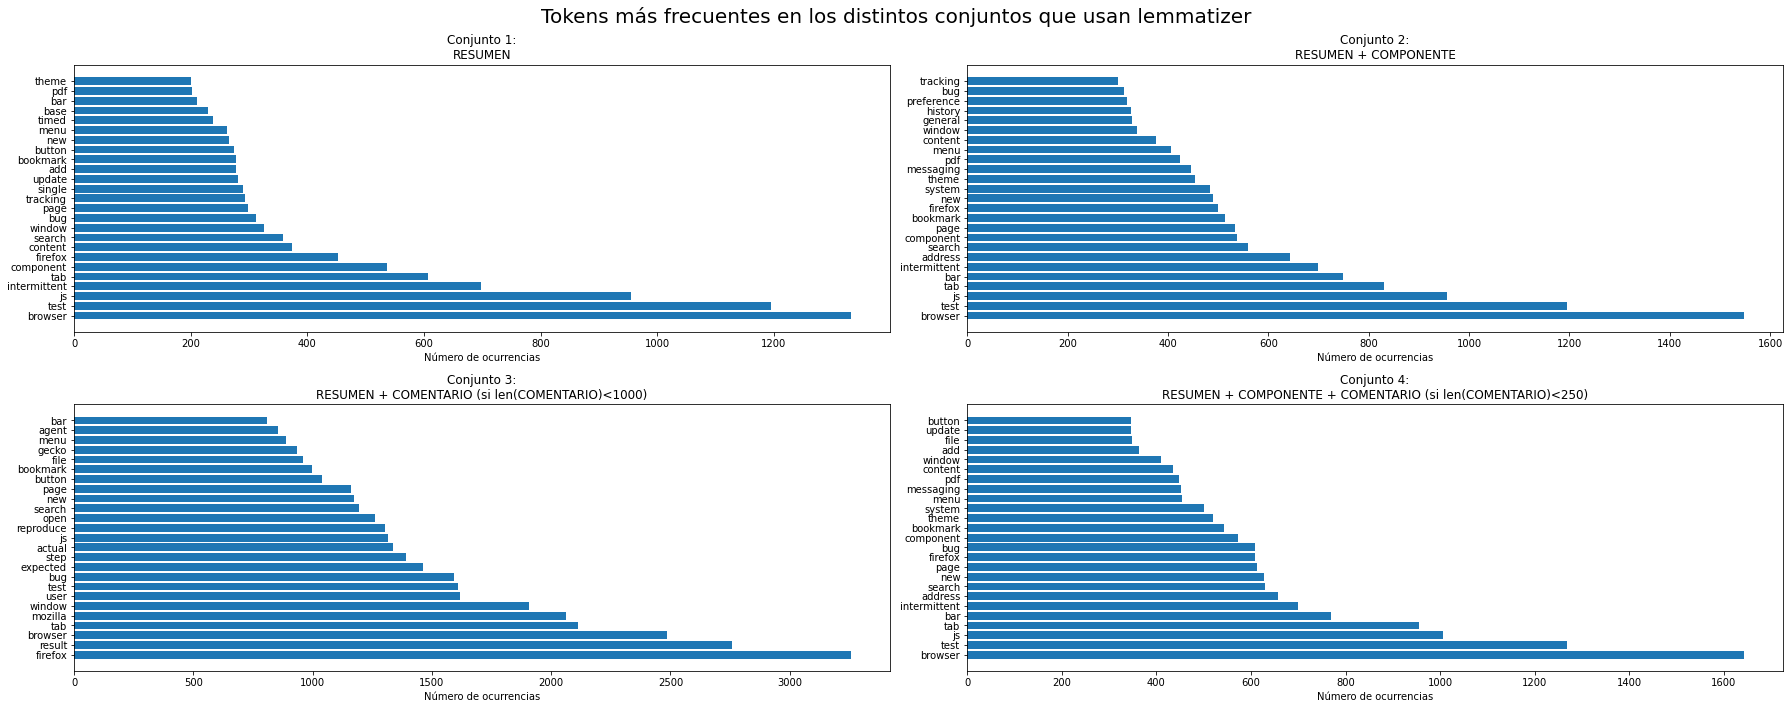

In [18]:
tokens1L_counter = Counter(word for tokens in df_reports['tokens1L'] for word in tokens)
tokens2L_counter = Counter(word for tokens in df_reports['tokens2L'] for word in tokens)
tokens3L_counter = Counter(word for tokens in df_reports['tokens3L'] for word in tokens)
tokens4L_counter = Counter(word for tokens in df_reports['tokens4L'] for word in tokens)

tokens1L_counter_25 = tokens1L_counter.most_common(25)
tokens2L_counter_25 = tokens2L_counter.most_common(25)
tokens3L_counter_25 = tokens3L_counter.most_common(25)
tokens4L_counter_25 = tokens4L_counter.most_common(25)

fig, axs = plt.subplots(2, 2, figsize=(25, 10))

axs[0, 0].barh(range(len(tokens1L_counter_25)), [count for word, count in tokens1L_counter_25], align='center')
axs[0, 0].set_yticks(range(len(tokens1L_counter_25)))
axs[0, 0].set_yticklabels([word for word, count in tokens1L_counter_25])
axs[0, 0].set_title('Conjunto 1:\nRESUMEN')
axs[0, 0].set_xlabel('Número de ocurrencias')

axs[0, 1].barh(range(len(tokens2L_counter_25)), [count for word, count in tokens2L_counter_25], align='center')
axs[0, 1].set_yticks(range(len(tokens2L_counter_25)))
axs[0, 1].set_yticklabels([word for word, count in tokens2L_counter_25])
axs[0, 1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0, 1].set_xlabel('Número de ocurrencias')

axs[1, 0].barh(range(len(tokens3L_counter_25)), [count for word, count in tokens3L_counter_25], align='center')
axs[1, 0].set_yticks(range(len(tokens3L_counter_25)))
axs[1, 0].set_yticklabels([word for word, count in tokens3L_counter_25])
axs[1, 0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1, 0].set_xlabel('Número de ocurrencias')

axs[1, 1].barh(range(len(tokens4L_counter_25)), [count for word, count in tokens4L_counter_25], align='center')
axs[1, 1].set_yticks(range(len(tokens4L_counter_25)))
axs[1, 1].set_yticklabels([word for word, count in tokens4L_counter_25])
axs[1, 1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1, 1].set_xlabel('Número de ocurrencias')

fig.suptitle('Tokens más frecuentes en los distintos conjuntos que usan lemmatizer', fontsize=20)
fig.tight_layout()
plt.show()

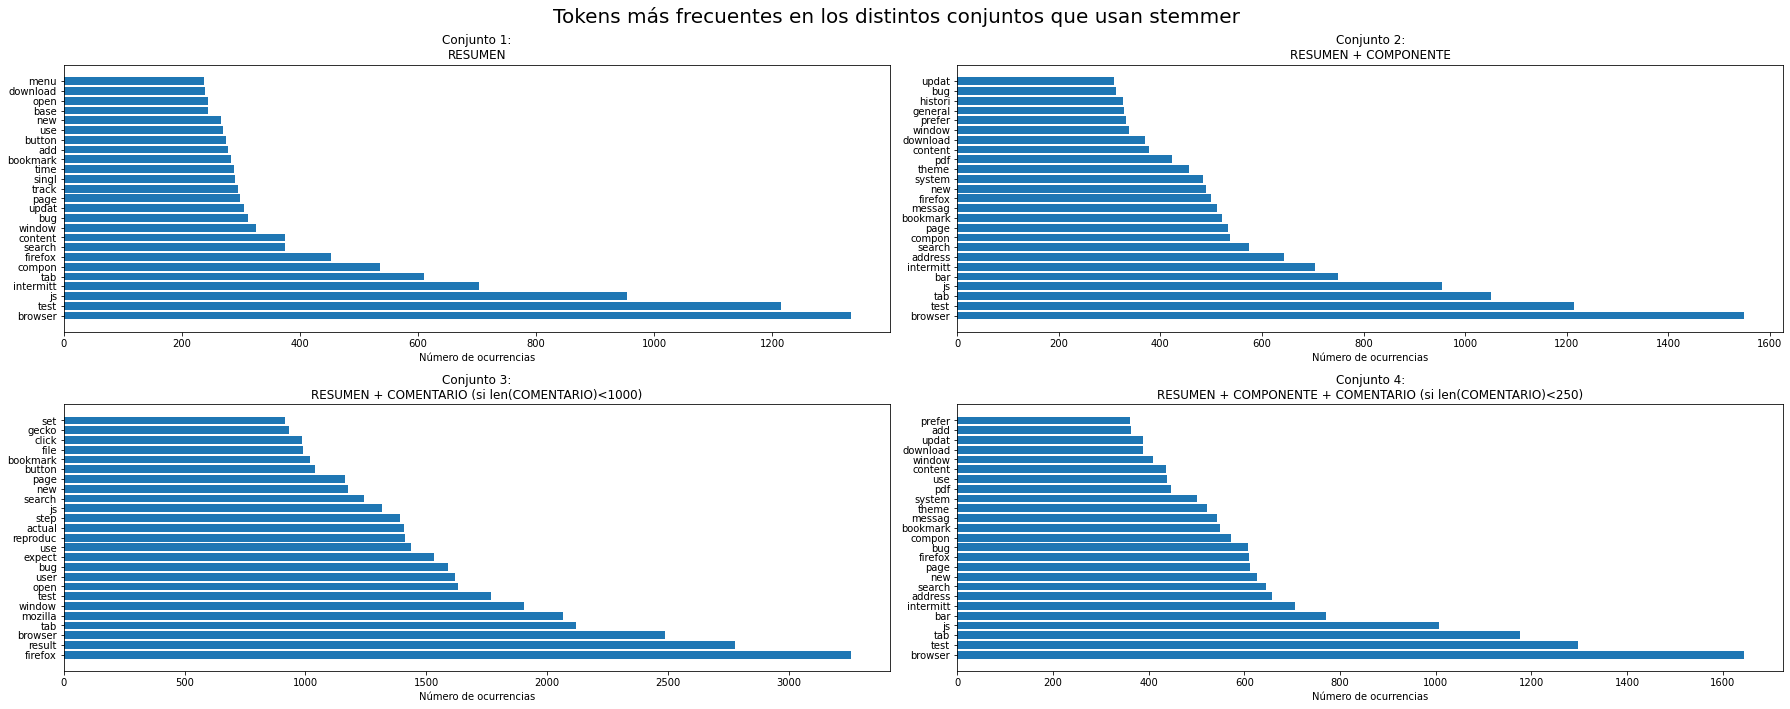

In [19]:
tokens1S_counter = Counter(word for tokens in df_reports['tokens1S'] for word in tokens)
tokens2S_counter = Counter(word for tokens in df_reports['tokens2S'] for word in tokens)
tokens3S_counter = Counter(word for tokens in df_reports['tokens3S'] for word in tokens)
tokens4S_counter = Counter(word for tokens in df_reports['tokens4S'] for word in tokens)

tokens1S_counter_25 = tokens1S_counter.most_common(25)
tokens2S_counter_25 = tokens2S_counter.most_common(25)
tokens3S_counter_25 = tokens3S_counter.most_common(25)
tokens4S_counter_25 = tokens4S_counter.most_common(25)

fig, axs = plt.subplots(2, 2, figsize=(25, 10))

axs[0, 0].barh(range(len(tokens1S_counter_25)), [count for word, count in tokens1S_counter_25], align='center')
axs[0, 0].set_yticks(range(len(tokens1S_counter_25)))
axs[0, 0].set_yticklabels([word for word, count in tokens1S_counter_25])
axs[0, 0].set_title('Conjunto 1:\nRESUMEN')
axs[0, 0].set_xlabel('Número de ocurrencias')

axs[0, 1].barh(range(len(tokens2S_counter_25)), [count for word, count in tokens2S_counter_25], align='center')
axs[0, 1].set_yticks(range(len(tokens2S_counter_25)))
axs[0, 1].set_yticklabels([word for word, count in tokens2S_counter_25])
axs[0, 1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0, 1].set_xlabel('Número de ocurrencias')

axs[1, 0].barh(range(len(tokens3S_counter_25)), [count for word, count in tokens3S_counter_25], align='center')
axs[1, 0].set_yticks(range(len(tokens3S_counter_25)))
axs[1, 0].set_yticklabels([word for word, count in tokens3S_counter_25])
axs[1, 0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1, 0].set_xlabel('Número de ocurrencias')

axs[1, 1].barh(range(len(tokens4S_counter_25)), [count for word, count in tokens4S_counter_25], align='center')
axs[1, 1].set_yticks(range(len(tokens4S_counter_25)))
axs[1, 1].set_yticklabels([word for word, count in tokens4S_counter_25])
axs[1, 1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1, 1].set_xlabel('Número de ocurrencias')

fig.suptitle('Tokens más frecuentes en los distintos conjuntos que usan stemmer', fontsize=20)
fig.tight_layout()
plt.show()

## Por parejas

In [20]:
df_duplicate_pairs = df_report_pairs[df_report_pairs.type == 'duplicate']

In [21]:
import warnings
warnings.filterwarnings('ignore')

df_duplicate_pairs['tokens1ML'] = df_duplicate_pairs['text1M'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens1DL'] = df_duplicate_pairs['text1D'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens2ML'] = df_duplicate_pairs['text2M'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens2DL'] = df_duplicate_pairs['text2D'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens3ML'] = df_duplicate_pairs['text3M'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens3DL'] = df_duplicate_pairs['text3D'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens4ML'] = df_duplicate_pairs['text4M'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens4DL'] = df_duplicate_pairs['text4D'].apply(preprocess_with_lemmatizer)

df_duplicate_pairs['unique_tokens1ML'] = df_duplicate_pairs['tokens1ML'].apply(set)
df_duplicate_pairs['unique_tokens1DL'] = df_duplicate_pairs['tokens1DL'].apply(set)
df_duplicate_pairs['unique_tokens2ML'] = df_duplicate_pairs['tokens2ML'].apply(set)
df_duplicate_pairs['unique_tokens2DL'] = df_duplicate_pairs['tokens2DL'].apply(set)
df_duplicate_pairs['unique_tokens3ML'] = df_duplicate_pairs['tokens3ML'].apply(set)
df_duplicate_pairs['unique_tokens3DL'] = df_duplicate_pairs['tokens3DL'].apply(set)
df_duplicate_pairs['unique_tokens4ML'] = df_duplicate_pairs['tokens4ML'].apply(set)
df_duplicate_pairs['unique_tokens4DL'] = df_duplicate_pairs['tokens4DL'].apply(set)

df_duplicate_pairs['unique_tokens_len1ML'] = df_duplicate_pairs['unique_tokens1ML'].apply(len)
df_duplicate_pairs['unique_tokens_len1DL'] = df_duplicate_pairs['unique_tokens1DL'].apply(len)
df_duplicate_pairs['unique_tokens_len2ML'] = df_duplicate_pairs['unique_tokens2ML'].apply(len)
df_duplicate_pairs['unique_tokens_len2DL'] = df_duplicate_pairs['unique_tokens2DL'].apply(len)
df_duplicate_pairs['unique_tokens_len3ML'] = df_duplicate_pairs['unique_tokens3ML'].apply(len)
df_duplicate_pairs['unique_tokens_len3DL'] = df_duplicate_pairs['unique_tokens3DL'].apply(len)
df_duplicate_pairs['unique_tokens_len4ML'] = df_duplicate_pairs['unique_tokens4ML'].apply(len)
df_duplicate_pairs['unique_tokens_len4DL'] = df_duplicate_pairs['unique_tokens4DL'].apply(len)

df_duplicate_pairs['common_tokens1L'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens1ML'] & row['unique_tokens1DL'], axis=1)
df_duplicate_pairs['common_tokens2L'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens2ML'] & row['unique_tokens2DL'], axis=1)
df_duplicate_pairs['common_tokens3L'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens3ML'] & row['unique_tokens3DL'], axis=1)
df_duplicate_pairs['common_tokens4L'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens4ML'] & row['unique_tokens4DL'], axis=1)

df_duplicate_pairs['common_tokens_len1L'] = df_duplicate_pairs['common_tokens1L'].apply(len)
df_duplicate_pairs['common_tokens_len2L'] = df_duplicate_pairs['common_tokens2L'].apply(len)
df_duplicate_pairs['common_tokens_len3L'] = df_duplicate_pairs['common_tokens3L'].apply(len)
df_duplicate_pairs['common_tokens_len4L'] = df_duplicate_pairs['common_tokens4L'].apply(len)

In [22]:
df_duplicate_pairs['tokens1MS'] = df_duplicate_pairs['text1M'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens1DS'] = df_duplicate_pairs['text1D'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens2MS'] = df_duplicate_pairs['text2M'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens2DS'] = df_duplicate_pairs['text2D'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens3MS'] = df_duplicate_pairs['text3M'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens3DS'] = df_duplicate_pairs['text3D'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens4MS'] = df_duplicate_pairs['text4M'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens4DS'] = df_duplicate_pairs['text4D'].apply(preprocess_with_stemmer)

df_duplicate_pairs['unique_tokens1MS'] = df_duplicate_pairs['tokens1MS'].apply(set)
df_duplicate_pairs['unique_tokens1DS'] = df_duplicate_pairs['tokens1DS'].apply(set)
df_duplicate_pairs['unique_tokens2MS'] = df_duplicate_pairs['tokens2MS'].apply(set)
df_duplicate_pairs['unique_tokens2DS'] = df_duplicate_pairs['tokens2DS'].apply(set)
df_duplicate_pairs['unique_tokens3MS'] = df_duplicate_pairs['tokens3MS'].apply(set)
df_duplicate_pairs['unique_tokens3DS'] = df_duplicate_pairs['tokens3DS'].apply(set)
df_duplicate_pairs['unique_tokens4MS'] = df_duplicate_pairs['tokens4MS'].apply(set)
df_duplicate_pairs['unique_tokens4DS'] = df_duplicate_pairs['tokens4DS'].apply(set)

df_duplicate_pairs['unique_tokens_len1MS'] = df_duplicate_pairs['unique_tokens1MS'].apply(len)
df_duplicate_pairs['unique_tokens_len1DS'] = df_duplicate_pairs['unique_tokens1DS'].apply(len)
df_duplicate_pairs['unique_tokens_len2MS'] = df_duplicate_pairs['unique_tokens2MS'].apply(len)
df_duplicate_pairs['unique_tokens_len2DS'] = df_duplicate_pairs['unique_tokens2DS'].apply(len)
df_duplicate_pairs['unique_tokens_len3MS'] = df_duplicate_pairs['unique_tokens3MS'].apply(len)
df_duplicate_pairs['unique_tokens_len3DS'] = df_duplicate_pairs['unique_tokens3DS'].apply(len)
df_duplicate_pairs['unique_tokens_len4MS'] = df_duplicate_pairs['unique_tokens4MS'].apply(len)
df_duplicate_pairs['unique_tokens_len4DS'] = df_duplicate_pairs['unique_tokens4DS'].apply(len)

df_duplicate_pairs['common_tokens1S'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens1MS'] & row['unique_tokens1DS'], axis=1)
df_duplicate_pairs['common_tokens2S'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens2MS'] & row['unique_tokens2DS'], axis=1)
df_duplicate_pairs['common_tokens3S'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens3MS'] & row['unique_tokens3DS'], axis=1)
df_duplicate_pairs['common_tokens4S'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens4MS'] & row['unique_tokens4DS'], axis=1)

df_duplicate_pairs['common_tokens_len1S'] = df_duplicate_pairs['common_tokens1S'].apply(len)
df_duplicate_pairs['common_tokens_len2S'] = df_duplicate_pairs['common_tokens2S'].apply(len)
df_duplicate_pairs['common_tokens_len3S'] = df_duplicate_pairs['common_tokens3S'].apply(len)
df_duplicate_pairs['common_tokens_len4S'] = df_duplicate_pairs['common_tokens4S'].apply(len)

In [23]:
df_duplicate_pairs[[
    'unique_tokens_len1ML','unique_tokens_len1DL','unique_tokens_len2ML','unique_tokens_len2DL',
    'unique_tokens_len3ML','unique_tokens_len3DL','unique_tokens_len4ML','unique_tokens_len4DL'
]].describe()

,unique_tokens_len1ML,unique_tokens_len1DL,unique_tokens_len2ML,unique_tokens_len2DL,unique_tokens_len3ML,unique_tokens_len3DL,unique_tokens_len4ML,unique_tokens_len4DL
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.649000,8.866000,9.992000,10.066000,26.742000,28.970000,11.053000,10.724000
std,3.247822,4.334147,3.308002,4.463358,18.466848,18.354291,4.472381,4.984844
min,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,3.000000,2.000000
25%,6.000000,6.000000,7.000000,7.000000,10.000000,12.000000,8.000000,7.000000
50%,9.000000,8.000000,10.000000,9.000000,22.000000,27.500000,10.000000,9.000000
75%,10.000000,11.000000,12.000000,12.000000,42.000000,43.000000,12.000000,13.000000
max,26.000000,25.000000,28.000000,28.000000,79.000000,80.000000,33.000000,31.000000


In [24]:
df_duplicate_pairs[[
    'unique_tokens_len1MS','unique_tokens_len1DS','unique_tokens_len2MS','unique_tokens_len2DS',
    'unique_tokens_len3MS','unique_tokens_len3DS','unique_tokens_len4MS','unique_tokens_len4DS'
]].describe()

,unique_tokens_len1MS,unique_tokens_len1DS,unique_tokens_len2MS,unique_tokens_len2DS,unique_tokens_len3MS,unique_tokens_len3DS,unique_tokens_len4MS,unique_tokens_len4DS
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.609000,8.824000,9.870000,9.944000,25.990000,28.135000,10.891000,10.574000
std,3.233353,4.305759,3.296053,4.442364,17.642141,17.549894,4.382045,4.914537
min,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,3.000000,2.000000
25%,6.000000,6.000000,7.000000,7.000000,10.000000,12.000000,8.000000,7.000000
50%,9.000000,8.000000,10.000000,9.000000,21.000000,27.000000,10.000000,9.000000
75%,10.000000,11.000000,12.000000,12.000000,41.000000,42.000000,12.000000,13.000000
max,26.000000,25.000000,28.000000,28.000000,77.000000,80.000000,33.000000,31.000000


In [25]:
df_duplicate_pairs[[
    'common_tokens_len1L','common_tokens_len2L','common_tokens_len3L','common_tokens_len4L'
]].describe()

,common_tokens_len1L,common_tokens_len2L,common_tokens_len3L,common_tokens_len4L
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.867000,4.824000,9.387000,4.942000
std,3.412177,3.640368,8.267259,3.700044
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,4.000000,2.000000
50%,3.000000,4.000000,7.000000,4.000000
75%,7.000000,8.000000,12.000000,8.000000
max,22.000000,22.000000,53.000000,22.000000


In [26]:
df_duplicate_pairs[[
    'common_tokens_len1S','common_tokens_len2S','common_tokens_len3S','common_tokens_len4S'
]].describe()

,common_tokens_len1S,common_tokens_len2S,common_tokens_len3S,common_tokens_len4S
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.005000,4.904000,9.570000,5.022000
std,3.334681,3.551253,8.182668,3.605068
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,4.000000,2.000000
50%,3.000000,4.000000,7.000000,4.000000
75%,7.000000,8.000000,13.000000,8.000000
max,22.000000,22.000000,54.000000,22.000000


In [27]:
TOP_TOKENS = 25
def get_TOP_most_frequent_common_tokens(df, column):
    rank = {}
    for i, row in df.iterrows():
        for t in row[column]:
            if t in rank:
                rank[t] +=1
            else:
                rank[t] = 1
    return sorted(rank.items(), key=lambda x: x[1], reverse=True)[:TOP_TOKENS]

rank_1L = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens1L')
rank_2L = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens2L')
rank_3L = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens3L')
rank_4L = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens4L')
rank_1S = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens1S')
rank_2S = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens2S')
rank_3S = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens3S')
rank_4S = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens4S')

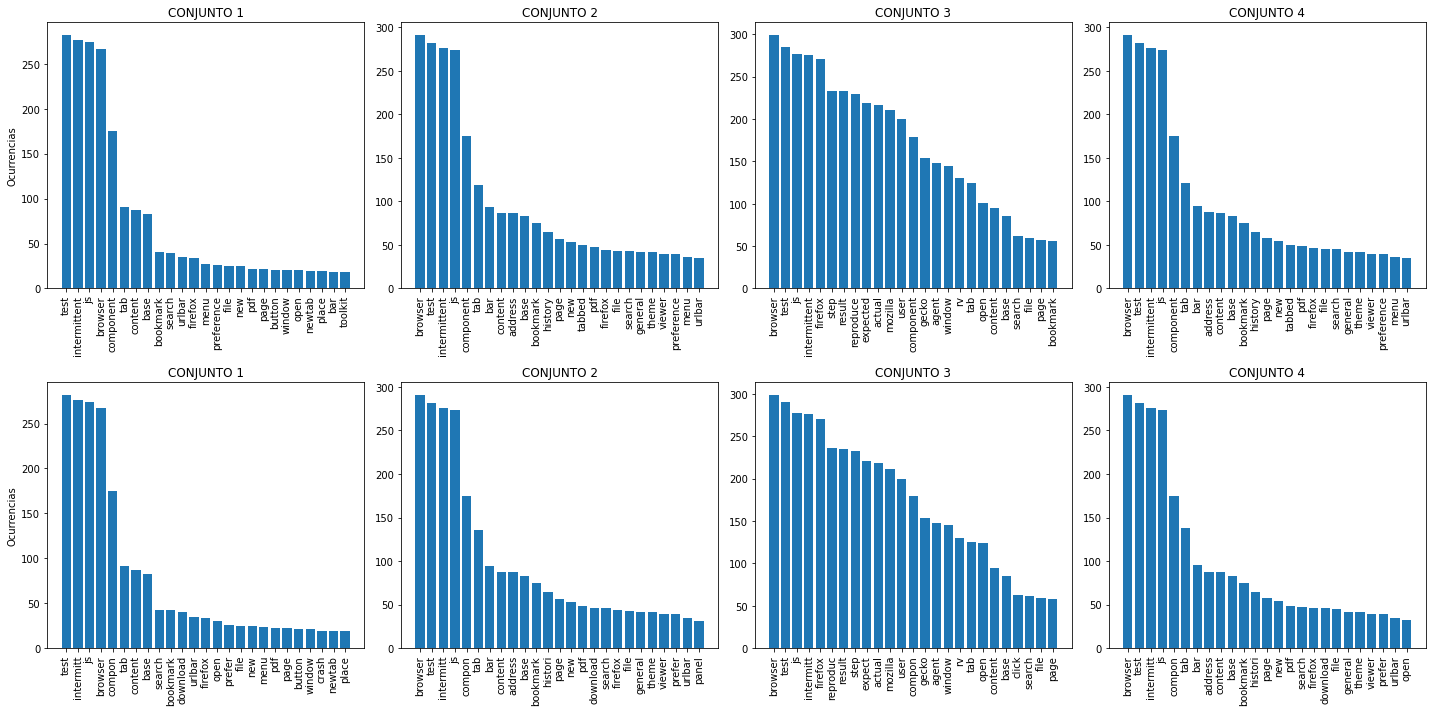

In [28]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))

# fig.set_title("Tokens compartidos entre Maestro y Duplicado más comunes")

axs[0,0].bar(range(len(rank_1L)), [x[1] for x in rank_1L], align='center')
axs[0,0].set_xticks(range(len(rank_1L)), [x[0] for x in rank_1L], rotation=90)
axs[0,0].set_ylabel('Ocurrencias')
axs[0,0].set_title('CONJUNTO 1')

axs[1,0].bar(range(len(rank_1S)), [x[1] for x in rank_1S], align='center')
axs[1,0].set_xticks(range(len(rank_1S)), [x[0] for x in rank_1S], rotation=90)
axs[1,0].set_ylabel('Ocurrencias')
axs[1,0].set_title('CONJUNTO 1')

axs[0,1].bar(range(len(rank_2L)), [x[1] for x in rank_2L], align='center')
axs[0,1].set_xticks(range(len(rank_2L)), [x[0] for x in rank_2L], rotation=90)
axs[0,1].set_title('CONJUNTO 2')

axs[1,1].bar(range(len(rank_2S)), [x[1] for x in rank_2S], align='center')
axs[1,1].set_xticks(range(len(rank_2S)), [x[0] for x in rank_2S], rotation=90)
axs[1,1].set_title('CONJUNTO 2')

axs[0,2].bar(range(len(rank_3L)), [x[1] for x in rank_3L], align='center')
axs[0,2].set_xticks(range(len(rank_3L)), [x[0] for x in rank_3L], rotation=90)
axs[0,2].set_title('CONJUNTO 3')

axs[1,2].bar(range(len(rank_3S)), [x[1] for x in rank_3S], align='center')
axs[1,2].set_xticks(range(len(rank_3S)), [x[0] for x in rank_3S], rotation=90)
axs[1,2].set_title('CONJUNTO 3')

axs[0,3].bar(range(len(rank_4L)), [x[1] for x in rank_4L], align='center')
axs[0,3].set_xticks(range(len(rank_4L)), [x[0] for x in rank_4L], rotation=90)
axs[0,3].set_title('CONJUNTO 4')

axs[1,3].bar(range(len(rank_4S)), [x[1] for x in rank_4S], align='center')
axs[1,3].set_xticks(range(len(rank_4S)), [x[0] for x in rank_4S], rotation=90)
axs[1,3].set_title('CONJUNTO 4')

fig.tight_layout()
plt.show()

# Añadir tokenes a dataframes

In [29]:
df_report_pairs['tokens1ML'] = df_report_pairs['text1M'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens2ML'] = df_report_pairs['text2M'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens3ML'] = df_report_pairs['text3M'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens4ML'] = df_report_pairs['text4M'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens1MS'] = df_report_pairs['text1M'].apply(preprocess_with_stemmer)
df_report_pairs['tokens2MS'] = df_report_pairs['text2M'].apply(preprocess_with_stemmer)
df_report_pairs['tokens3MS'] = df_report_pairs['text3M'].apply(preprocess_with_stemmer)
df_report_pairs['tokens4MS'] = df_report_pairs['text4M'].apply(preprocess_with_stemmer)

df_report_pairs['tokens1DL'] = df_report_pairs['text1D'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens2DL'] = df_report_pairs['text2D'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens3DL'] = df_report_pairs['text3D'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens4DL'] = df_report_pairs['text4D'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens1DS'] = df_report_pairs['text1D'].apply(preprocess_with_stemmer)
df_report_pairs['tokens2DS'] = df_report_pairs['text2D'].apply(preprocess_with_stemmer)
df_report_pairs['tokens3DS'] = df_report_pairs['text3D'].apply(preprocess_with_stemmer)
df_report_pairs['tokens4DS'] = df_report_pairs['text4D'].apply(preprocess_with_stemmer)

# Persistir

In [30]:
import os

if not os.path.exists('data'):
    os.makedirs('data')

df_reports.to_pickle('data/preprocessed_reports.pkl')
df_report_pairs[[
    'type', 'id_M', 'id_D', 'statusM', 'statusD',  'componentM', 'componentD',
    'summaryM', 'summaryD', 'commentsM',  'commentsD',
    'text1M', 'text1D', 'text2M', 'text2D', 'text3M', 'text3D', 'text4M', 'text4D',
    'tokens1ML', 'tokens2ML', 'tokens3ML', 'tokens4ML', 'tokens1DL', 'tokens2DL', 'tokens3DL', 'tokens4DL',
    'tokens1MS', 'tokens2MS', 'tokens3MS', 'tokens4MS', 'tokens1DS', 'tokens2DS', 'tokens3DS', 'tokens4DS'
]].to_pickle('data/preprocessed_report_pairs.pkl')